Found 26000 files belonging to 26 classes.
Using 20800 files for training.
Found 26000 files belonging to 26 classes.
Using 5200 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


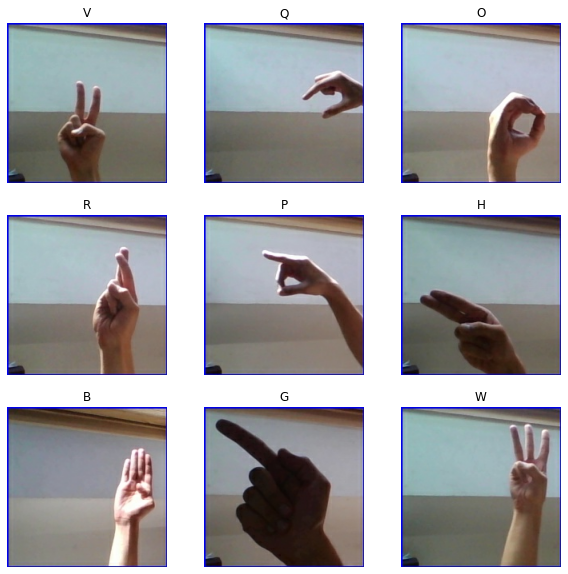

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1Z03YaFEvmGW5dapUex99nQF_Vxa2lriJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('asl_1000.zip')
!unzip -q asl_1000.zip

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

batch_size = 32 # The batch size
img_height = 200 # Image resize height
img_width = 200 # Image resize width
data_dir = "asl_1000/asl_alphabet_train" # Data directory

# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

import matplotlib.pyplot as plt
class_names = train_ds.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [2]:
# Rescaling images
normalization_layer = tf.keras.layers.Rescaling(1./255)
# normalize train_ds
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds_normal, labels_train = next(iter(normalized_ds))
# normalize val_ds
normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_normal, labels_val = next(iter(normalized_ds))

In [3]:
### Building a CNN ###
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Conv2D, MaxPool2D, Flatten, Rescaling
from tensorflow.keras.optimizers import *


num_classes = 26
def build_model():
  model = Sequential()
  model.add(Rescaling(1./255))
  model.add(Conv2D(filters = 10, kernel_size = (20,20), activation = "relu", input_shape = (200,200,3)))
  model.add(MaxPool2D(pool_size = (10, 10)))
  model.add(Conv2D(filters = 20, kernel_size = (10,10),activation = "relu"))
  model.add(MaxPool2D(pool_size = (5, 5)))
  model.add(Flatten())
  model.add(Dense(100, activation="relu"))
  model.add(Dense(num_classes, activation = "softmax"))
  return model

model = build_model()
model.build((None,200,200,3))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 181, 181, 10)      12010     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 20)          20020     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 20)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 20)                0

Epoch 1/3
650/650 [==============================] - 4884s 8s/step - loss: 0.6225 - accuracy: 0.8029 - val_loss: 0.5128 - val_accuracy: 0.8373
Epoch 2/3
650/650 [==============================] - 5024s 8s/step - loss: 0.4088 - accuracy: 0.8659 - val_loss: 0.4284 - val_accuracy: 0.8465
Epoch 3/3
650/650 [==============================] - 4846s 7s/step - loss: 0.3100 - accuracy: 0.8949 - val_loss: 0.2900 - val_accuracy: 0.8975


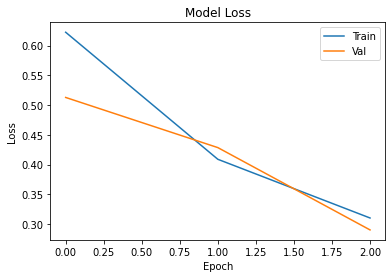

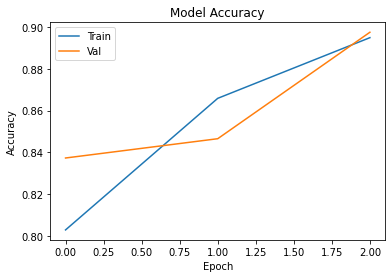

In [6]:
### Runing the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=optimizer, 
              metrics=['accuracy'])
epochs = 3
batchsize = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batchsize
)


def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

plot_losses(history)
plot_accuracies(history)